## Kredi Kartı Sahtekarlık Tespiti - Model Eğitimi
### Bu notebook, kredi kartı sahtekarlık tespiti için çeşitli modellerin eğitilmesi sürecini içermektedir.

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, 
    precision_recall_curve, average_precision_score
)

# Özel modüllerimizi import edelim
import sys
sys.path.append('..')  # Ana dizini ekleyelim

from src.utils.logger import setup_logger
from src.constants import TARGET, NUMERICAL_FEATURES, RANDOM_STATE, MODELS_DIR
from src.models.xgboost import train_xgboost, evaluate_xgboost
from src.models.logistic_regression import train_logistic_regression, evaluate_logistic_regression
from src.preprocessing.pipeline import FraudPreprocessor
from src.config import XGBOOST_PARAMS, LOGISTIC_REGRESSION_PARAMS

In [2]:
# Logger'ı ayarlayalım
logger = setup_logger("model_training_notebook")

# İşlenmiş eğitim ve test veri setlerini yükleyelim
processed_dir = '../data/processed/'

# Dengelenmiş eğitim setini yükleyelim (SMOTE + Undersampling uygulanmış)
balanced_train = pd.read_csv(f'{processed_dir}balanced_train.csv')
print(f"Dengelenmiş eğitim seti boyutu: {balanced_train.shape}")

# İşlenmiş test setini yükleyelim
processed_test = pd.read_csv(f'{processed_dir}processed_test.csv')
print(f"İşlenmiş test seti boyutu: {processed_test.shape}")


Dengelenmiş eğitim seti boyutu: (68235, 41)
İşlenmiş test seti boyutu: (56962, 41)


In [3]:
with open('../models/preprocessing_pipeline.pkl', 'rb') as f:
    preprocessor = pickle.load(f)

# Eğitim seti
X_train, y_train = preprocessor.get_features_and_target(balanced_train)

# Test seti
X_test, y_test = preprocessor.get_features_and_target(processed_test)

print(f"Eğitim özellikleri: {X_train.shape}, Eğitim hedefleri: {y_train.shape}")
print(f"Test özellikleri: {X_test.shape}, Test hedefleri: {y_test.shape}")


2025-05-08 22:17:01,093 | INFO | pipeline.py:110 | Splitting features and target
2025-05-08 22:17:01,099 | INFO | pipeline.py:110 | Splitting features and target


Eğitim özellikleri: (68235, 40), Eğitim hedefleri: (68235,)
Test özellikleri: (56962, 40), Test hedefleri: (56962,)


In [4]:
# Hücre 3: XGBoost modelini eğitme
logger.info("XGBoost modeli eğitiliyor...")
xgb_model = train_xgboost(X_train, y_train, params=XGBOOST_PARAMS)

# XGBoost eğitim seti değerlendirmesi
train_probs_xgb = xgb_model.predict(X_train)
# Probability değerlerini binary sınıf tahminlerine çevirelim (threshold=0.5)
train_preds_xgb = (train_probs_xgb >= 0.5).astype(int)

print("\nEğitim Seti Performansı (XGBoost):")
print("Accuracy:", accuracy_score(y_train, train_preds_xgb))
print("Precision:", precision_score(y_train, train_preds_xgb))
print("Recall:", recall_score(y_train, train_preds_xgb))
print("F1 Score:", f1_score(y_train, train_preds_xgb))

2025-05-08 22:17:01,115 | INFO | 304028296.py:2 | XGBoost modeli eğitiliyor...
2025-05-08 22:17:01,116 | INFO | base_model.py:29 | Initialized xgboost model
2025-05-08 22:17:01,117 | INFO | xgboost.py:31 | Training XGBoost model with 68235 samples


[22:17:01] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




2025-05-08 22:17:26,852 | INFO | xgboost.py:60 | XGBoost model training completed
2025-05-08 22:17:26,855 | INFO | xgboost.py:68 | Making predictions on 68235 samples



Eğitim Seti Performansı (XGBoost):
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [5]:
# Test seti üzerinde değerlendirelim
test_probs_xgb = xgb_model.predict(X_test)
# Probability değerlerini binary sınıf tahminlerine çevirelim (threshold=0.5)
test_preds_xgb = (test_probs_xgb >= 0.5).astype(int)

print("\nTest Seti Performansı (XGBoost):")
print("Accuracy:", accuracy_score(y_test, test_preds_xgb))
print("Precision:", precision_score(y_test, test_preds_xgb))
print("Recall:", recall_score(y_test, test_preds_xgb))
print("F1 Score:", f1_score(y_test, test_preds_xgb))

# Sınıflandırma raporu
print("\nSınıflandırma Raporu (XGBoost):")
report = classification_report(y_test, test_preds_xgb)
print(report)

2025-05-08 22:17:27,132 | INFO | xgboost.py:68 | Making predictions on 56962 samples



Test Seti Performansı (XGBoost):
Accuracy: 0.9991046662687406
Precision: 0.688
Recall: 0.8775510204081632
F1 Score: 0.7713004484304933

Sınıflandırma Raporu (XGBoost):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.69      0.88      0.77        98

    accuracy                           1.00     56962
   macro avg       0.84      0.94      0.89     56962
weighted avg       1.00      1.00      1.00     56962



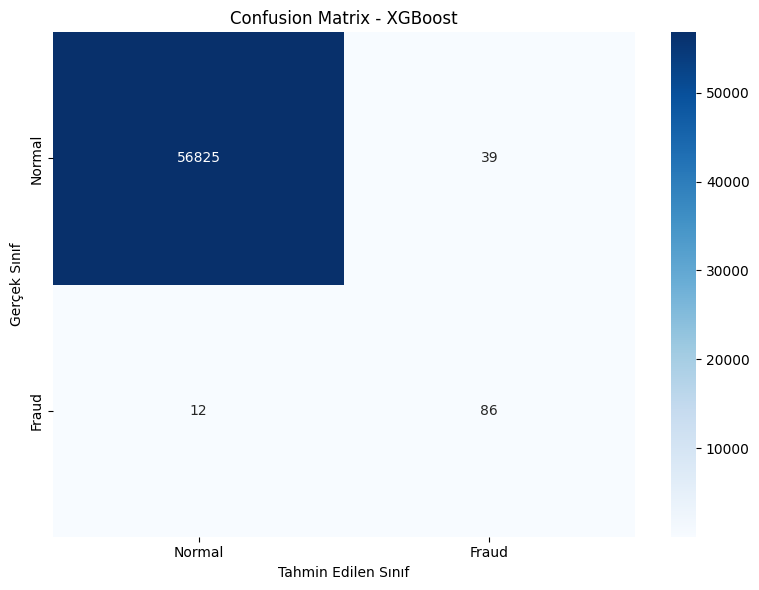

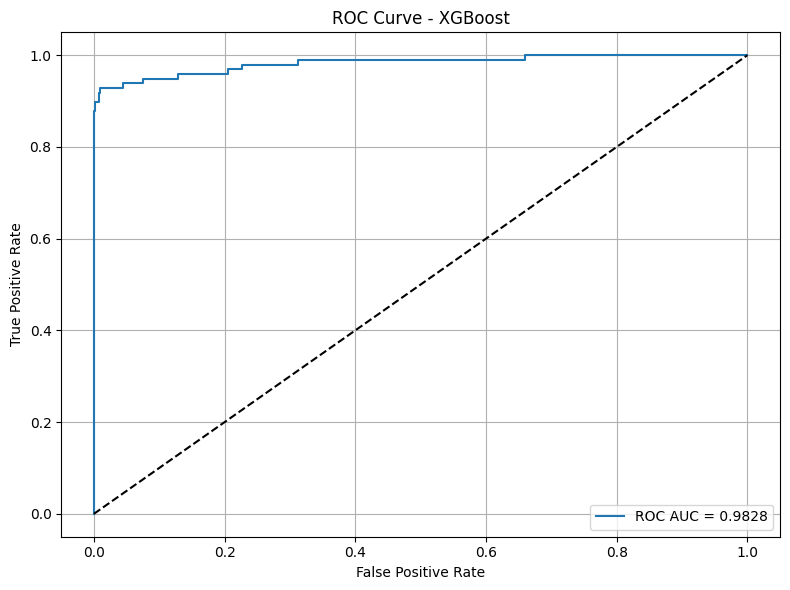

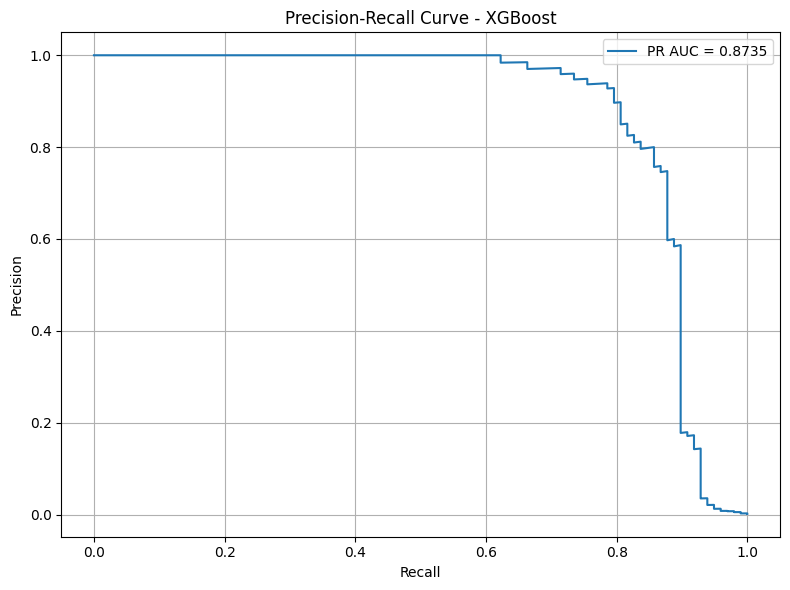

In [6]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, test_preds_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Fraud'],
            yticklabels=['Normal', 'Fraud'])
plt.title('Confusion Matrix - XGBoost')
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.tight_layout()
plt.show()

# ROC Eğrisi
fpr, tpr, _ = roc_curve(y_test, test_probs_xgb)
roc_auc = roc_auc_score(y_test, test_probs_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Precision-Recall Eğrisi
precision, recall, _ = precision_recall_curve(y_test, test_probs_xgb)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - XGBoost')
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

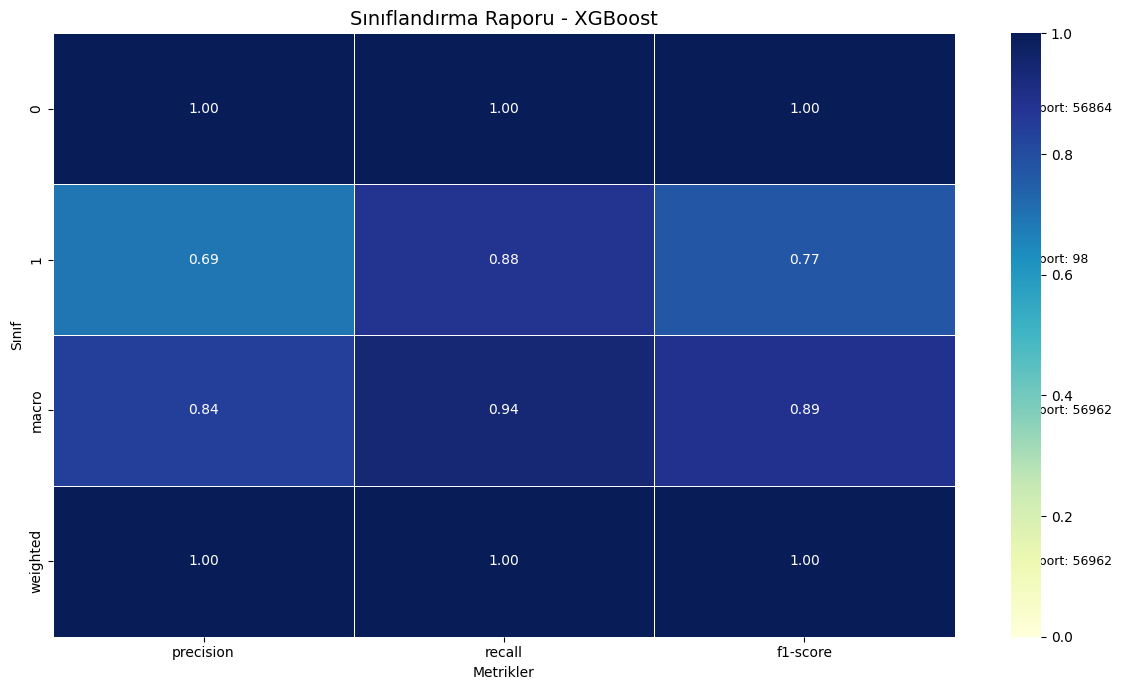

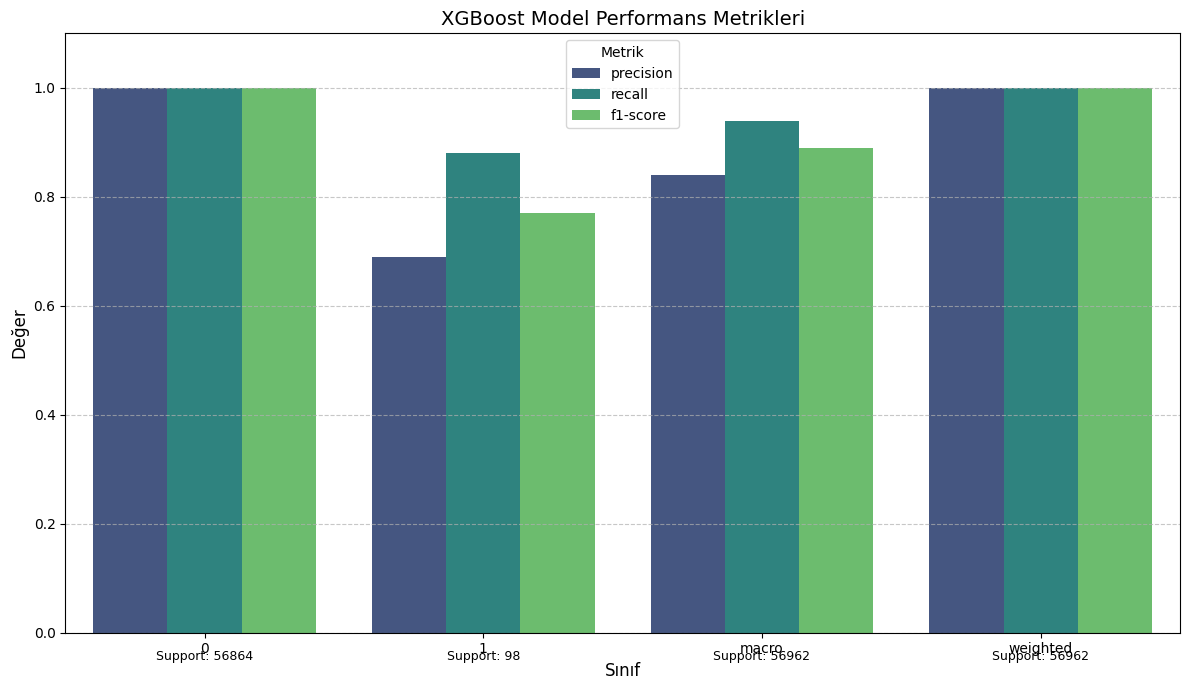

In [7]:
# Rapor metnini DataFrame'e çevirelim
from src.utils.visualizations import classification_report_to_dataframe

# Sınıflandırma raporunu DataFrame'e çevirelim
report_df = classification_report_to_dataframe(report)

# Başarı metriklerini görselleştirme
plt.figure(figsize=(12, 7))

# Isı haritası için değerleri hazırlayalım
metrics_df = report_df.copy()
metrics_df = metrics_df.set_index('class')
metrics_df = metrics_df[['precision', 'recall', 'f1-score']]

# NaN değerleri 0 ile dolduralım (görselleştirme için)
metrics_df = metrics_df.fillna(0)

# Isı haritası
ax = sns.heatmap(metrics_df, annot=True, cmap="YlGnBu", fmt='.2f', 
                linewidths=.5, vmin=0, vmax=1)
plt.title('Sınıflandırma Raporu - XGBoost', fontsize=14)
plt.ylabel('Sınıf')
plt.xlabel('Metrikler')

# Support değerlerini ekleyelim
for i, (_, row) in enumerate(report_df.iterrows()):
    plt.text(3.2, i + 0.5, f"Support: {row['support']}", 
             va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.show()

# Metrikleri çubuk grafik olarak gösterme
plt.figure(figsize=(12, 7))

# Uzun format DataFrame'e dönüştürme
metrics_long = pd.melt(report_df, 
                      id_vars=['class', 'support'],
                      value_vars=['precision', 'recall', 'f1-score'],
                      var_name='metric', 
                      value_name='value')

# NaN değerlerini filtreleyebiliriz
metrics_long = metrics_long.dropna(subset=['value'])

# Çubuk grafik
sns.barplot(x='class', y='value', hue='metric', data=metrics_long, palette='viridis')
plt.title('XGBoost Model Performans Metrikleri', fontsize=14)
plt.ylabel('Değer', fontsize=12)
plt.xlabel('Sınıf', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Metrik')

# Support değerlerini ekleyelim
for i, cls in enumerate(report_df['class'].unique()):
    support = report_df[report_df['class'] == cls]['support'].values[0]
    plt.text(i, -0.05, f"Support: {support}", ha='center', fontsize=9)

plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()

In [8]:
logger.info("Lojistik Regresyon modeli eğitiliyor...")
lr_model = train_logistic_regression(X_train, y_train, LOGISTIC_REGRESSION_PARAMS)

# Eğitim seti üzerinde değerlendirelim
train_preds_lr = lr_model.predict(X_train)
train_probs_lr = lr_model.predict_proba(X_train)[:, 1]

print("\nEğitim Seti Performansı (Lojistik Regresyon):")
print("Accuracy:", accuracy_score(y_train, train_preds_lr))
print("Precision:", precision_score(y_train, train_preds_lr))
print("Recall:", recall_score(y_train, train_preds_lr))
print("F1 Score:", f1_score(y_train, train_preds_lr))

2025-05-08 22:17:28,084 | INFO | 3948134325.py:1 | Lojistik Regresyon modeli eğitiliyor...
2025-05-08 22:17:28,085 | INFO | base_model.py:29 | Initialized logistic_regression model
2025-05-08 22:17:28,085 | INFO | logistic_regression.py:36 | Training Logistic Regression model with 68235 samples
2025-05-08 22:17:28,747 | INFO | logistic_regression.py:39 | Logistic Regression model training completed
2025-05-08 22:17:28,748 | INFO | logistic_regression.py:47 | Making predictions on 68235 samples
2025-05-08 22:17:28,761 | INFO | logistic_regression.py:55 | Making probability predictions on 68235 samples



Eğitim Seti Performansı (Lojistik Regresyon):
Accuracy: 0.9775335238513959
Precision: 0.9721331908831908
Recall: 0.9601231039788964
F1 Score: 0.9660908226238138


In [9]:
# Test seti üzerinde değerlendirelim
test_preds_lr = lr_model.predict(X_test)
test_probs_lr = lr_model.predict_proba(X_test)[:, 1]

print("\nTest Seti Performansı (Lojistik Regresyon):")
print("Accuracy:", accuracy_score(y_test, test_preds_lr))
print("Precision:", precision_score(y_test, test_preds_lr))
print("Recall:", recall_score(y_test, test_preds_lr))
print("F1 Score:", f1_score(y_test, test_preds_lr))

# Sınıflandırma raporu
print("\nSınıflandırma Raporu (Lojistik Regresyon):")
report = classification_report(y_test, test_preds_lr)
print(report)


2025-05-08 22:17:28,793 | INFO | logistic_regression.py:47 | Making predictions on 56962 samples
2025-05-08 22:17:28,804 | INFO | logistic_regression.py:55 | Making probability predictions on 56962 samples



Test Seti Performansı (Lojistik Regresyon):
Accuracy: 0.9848671043853797
Precision: 0.09361702127659574
Recall: 0.8979591836734694
F1 Score: 0.16955684007707128

Sınıflandırma Raporu (Lojistik Regresyon):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.09      0.90      0.17        98

    accuracy                           0.98     56962
   macro avg       0.55      0.94      0.58     56962
weighted avg       1.00      0.98      0.99     56962



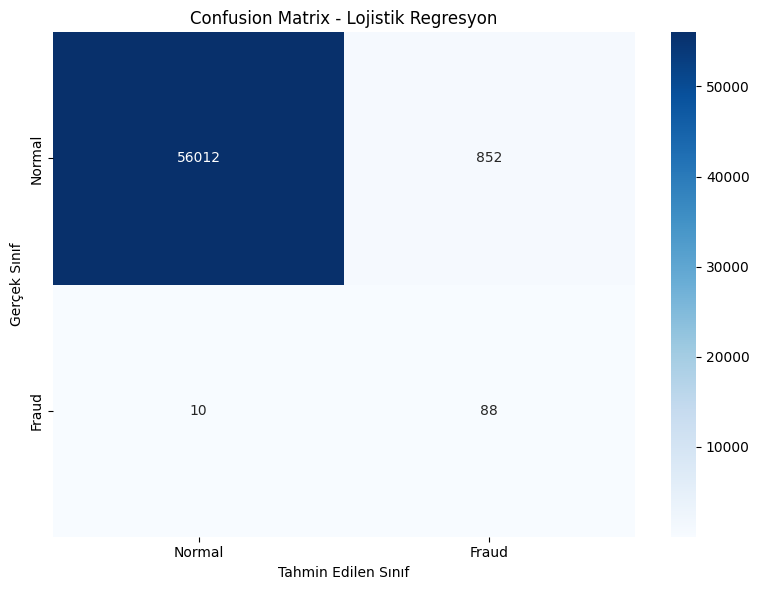

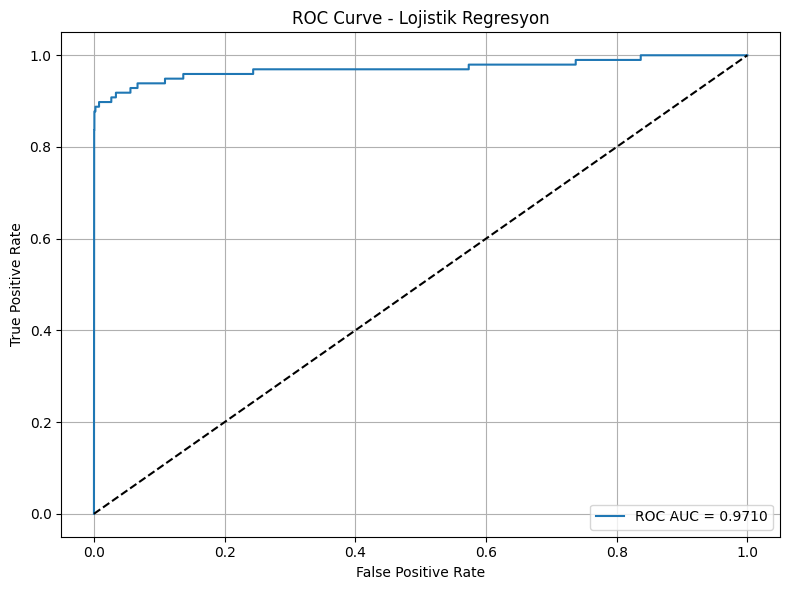

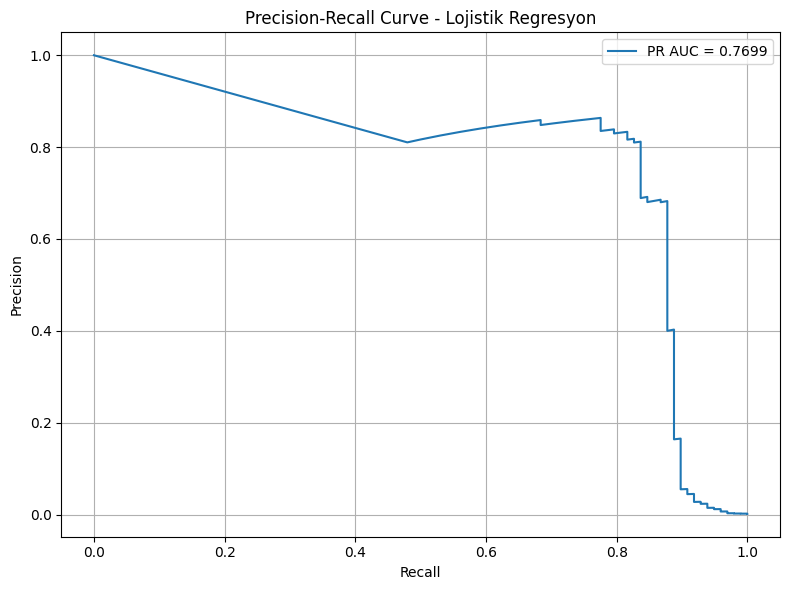

In [10]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, test_preds_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Fraud'],
            yticklabels=['Normal', 'Fraud'])
plt.title('Confusion Matrix - Lojistik Regresyon')
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.tight_layout()
plt.show()

# ROC Eğrisi
fpr, tpr, _ = roc_curve(y_test, test_probs_lr)
roc_auc = roc_auc_score(y_test, test_probs_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Lojistik Regresyon')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Precision-Recall Eğrisi  
precision, recall, _ = precision_recall_curve(y_test, test_probs_lr)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Lojistik Regresyon')
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


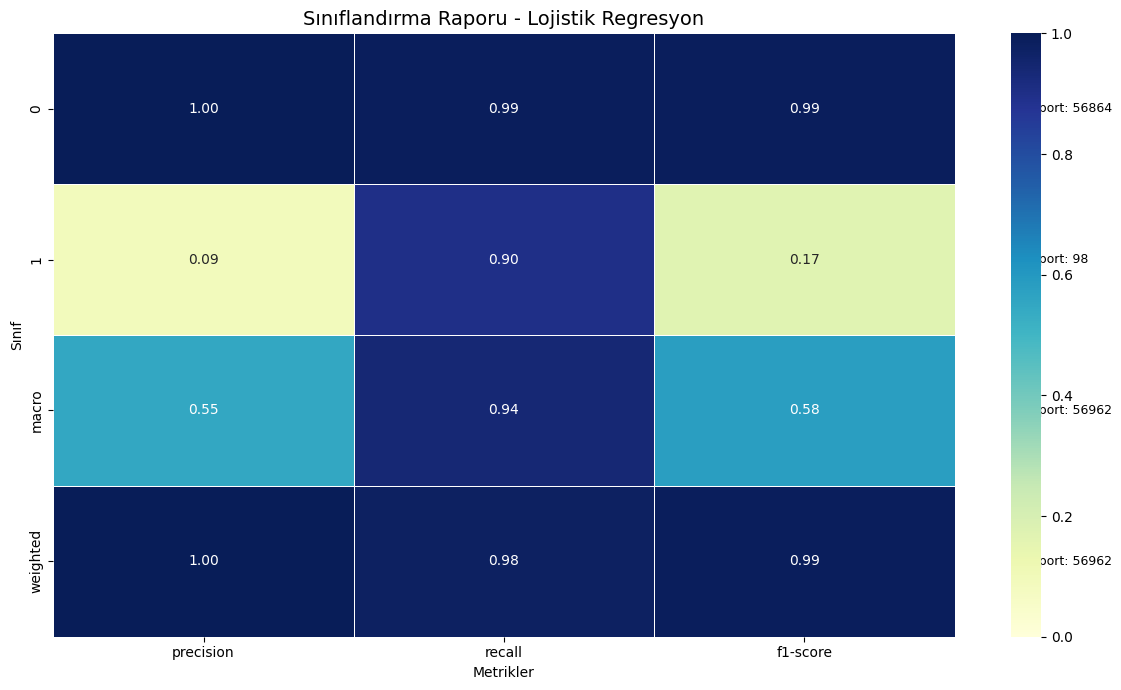

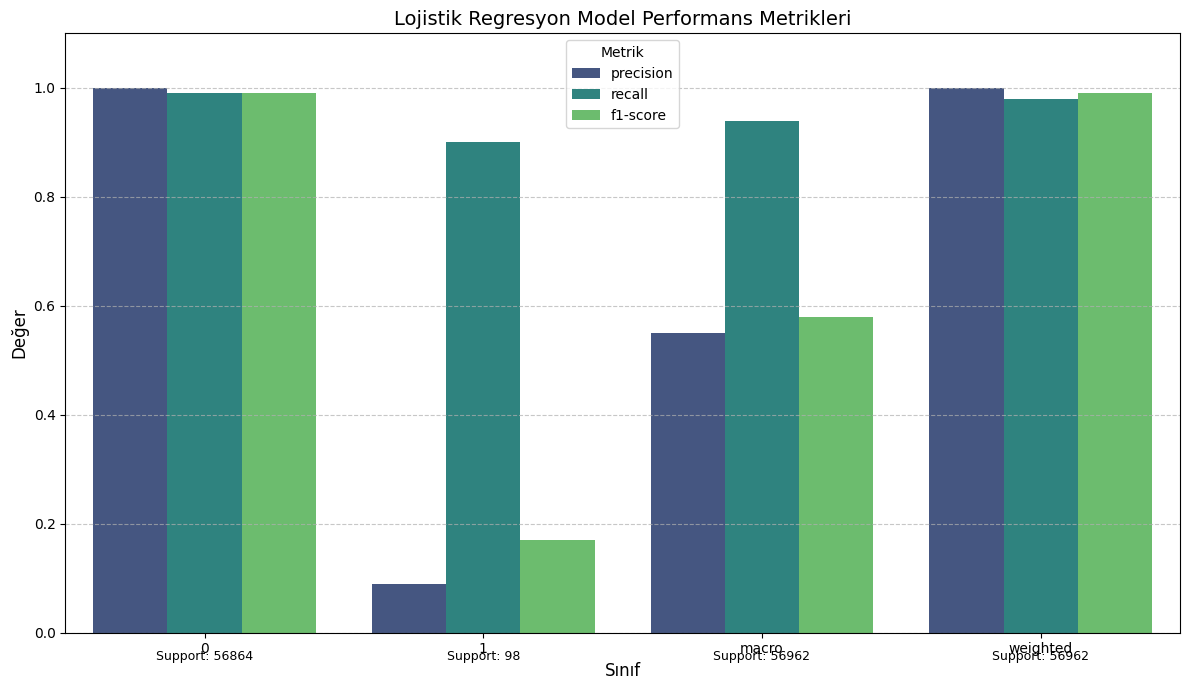

In [11]:
# Sınıflandırma raporunu DataFrame'e çevirelim
report_df = classification_report_to_dataframe(report)

# Başarı metriklerini görselleştirme
plt.figure(figsize=(12, 7))

# Isı haritası için değerleri hazırlayalım
metrics_df = report_df.copy()
metrics_df = metrics_df.set_index('class')
metrics_df = metrics_df[['precision', 'recall', 'f1-score']]

# NaN değerleri 0 ile dolduralım (görselleştirme için)
metrics_df = metrics_df.fillna(0)

# Isı haritası
ax = sns.heatmap(metrics_df, annot=True, cmap="YlGnBu", fmt='.2f', 
                linewidths=.5, vmin=0, vmax=1)
plt.title('Sınıflandırma Raporu - Lojistik Regresyon', fontsize=14)
plt.ylabel('Sınıf')
plt.xlabel('Metrikler')

# Support değerlerini ekleyelim
for i, (_, row) in enumerate(report_df.iterrows()):
    plt.text(3.2, i + 0.5, f"Support: {row['support']}", 
             va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.show()

# Metrikleri çubuk grafik olarak gösterme
plt.figure(figsize=(12, 7))

# Uzun format DataFrame'e dönüştürme
metrics_long = pd.melt(report_df, 
                      id_vars=['class', 'support'],
                      value_vars=['precision', 'recall', 'f1-score'],
                      var_name='metric', 
                      value_name='value')

# NaN değerlerini filtreleyebiliriz
metrics_long = metrics_long.dropna(subset=['value'])

# Çubuk grafik
sns.barplot(x='class', y='value', hue='metric', data=metrics_long, palette='viridis')
plt.title('Lojistik Regresyon Model Performans Metrikleri', fontsize=14)
plt.ylabel('Değer', fontsize=12)
plt.xlabel('Sınıf', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Metrik')

# Support değerlerini ekleyelim
for i, cls in enumerate(report_df['class'].unique()):
    support = report_df[report_df['class'] == cls]['support'].values[0]
    plt.text(i, -0.05, f"Support: {support}", ha='center', fontsize=9)

plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()

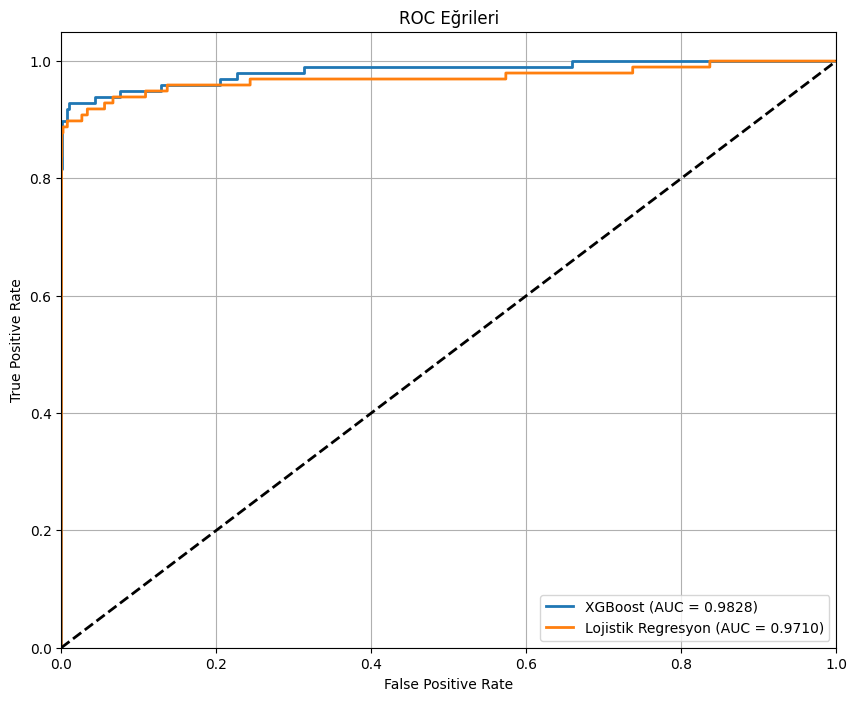

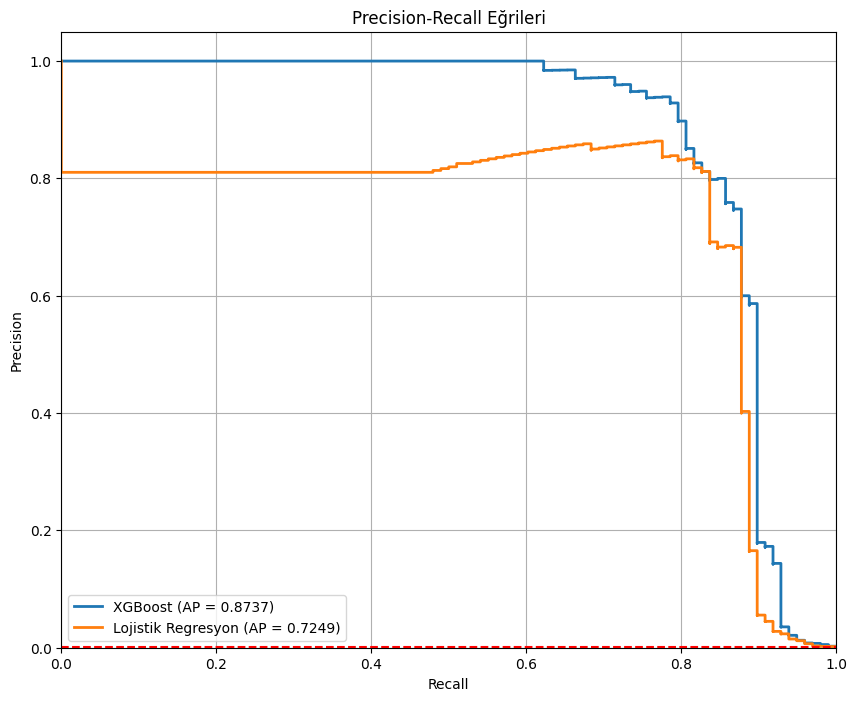

In [12]:
# ROC eğrilerini karşılaştıralım
plt.figure(figsize=(10, 8))

# XGBoost için ROC eğrisi
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, test_probs_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.plot(fpr_xgb, tpr_xgb, lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.4f})')

# Lojistik Regresyon için ROC eğrisi
fpr_lr, tpr_lr, _ = roc_curve(y_test, test_probs_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, lw=2, label=f'Lojistik Regresyon (AUC = {roc_auc_lr:.4f})')

# Tesadüfi tahmin için çizgi
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrileri')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Precision-Recall eğrilerini çizelim
plt.figure(figsize=(10, 8))

# XGBoost için PR eğrisi
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, test_probs_xgb)
avg_precision_xgb = average_precision_score(y_test, test_probs_xgb)
plt.step(recall_xgb, precision_xgb, where='post', lw=2, 
         label=f'XGBoost (AP = {avg_precision_xgb:.4f})')

# Lojistik Regresyon için PR eğrisi
precision_lr, recall_lr, _ = precision_recall_curve(y_test, test_probs_lr)
avg_precision_lr = average_precision_score(y_test, test_probs_lr)
plt.step(recall_lr, precision_lr, where='post', lw=2, 
         label=f'Lojistik Regresyon (AP = {avg_precision_lr:.4f})')

# Rastgele sınıflandırıcı için çizgi (veri setinin ortalama pozitif oranı)
plt.axhline(y=np.mean(y_test), linestyle='--', color='r')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Eğrileri')
plt.legend(loc="best")
plt.grid(True)
plt.show()

C:\Users\PC\AppData\Local\Temp\ipykernel_14656\2949954813.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


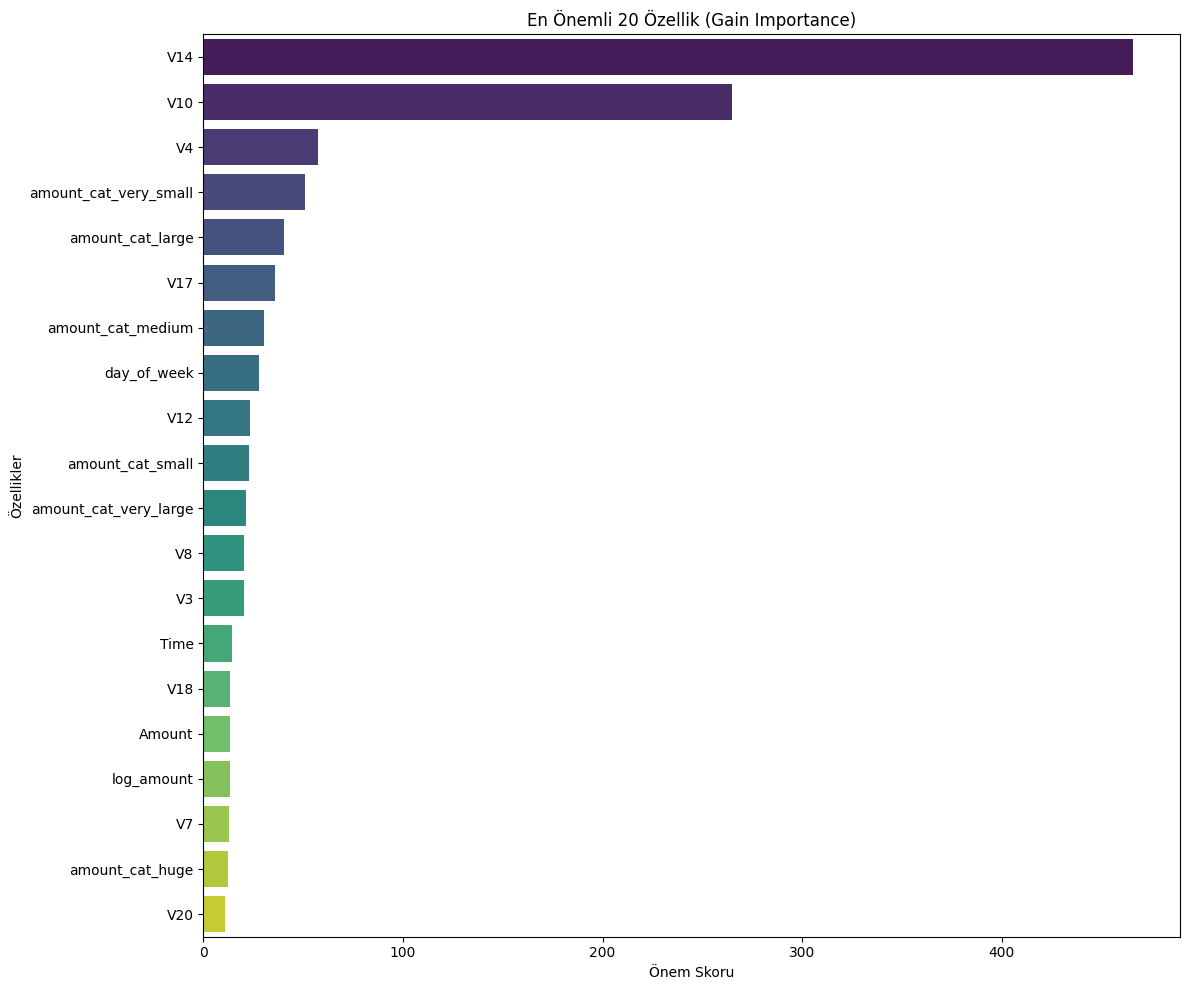

In [13]:
# XGBoost modeli için özellik önemini alalım
try:
    # 1. Yöntem: Doğrudan modelden özellik önemi alma
    importance_dict = xgb_model.model.get_score(importance_type='gain')
    
    # Feature isimlerini eşleştirme (f0, f1 -> gerçek isimler)
    feature_importance = pd.DataFrame({
        'feature': [X_train.columns[int(k[1:])] if k.startswith('f') else k 
                   for k in importance_dict.keys()],
        'importance': list(importance_dict.values())
    }).sort_values('importance', ascending=False).head(20)
    
    # 2. Yöntem: Alternatif olarak weight importance
    if feature_importance.empty:
        importance_dict = xgb_model.model.get_score(importance_type='weight')
        feature_importance = pd.DataFrame({
            'feature': [X_train.columns[int(k[1:])] if k.startswith('f') else k 
                       for k in importance_dict.keys()],
            'importance': list(importance_dict.values())
        }).sort_values('importance', ascending=False).head(20)

except Exception as e:
    print(f"Hata oluştu: {str(e)}")
    feature_importance = pd.DataFrame({'feature': [], 'importance': []})

# Özellik önemini görselleştirelim
if not feature_importance.empty:
    plt.figure(figsize=(12, 10))
    sns.barplot(
        x='importance', 
        y='feature', 
        data=feature_importance,
        palette='viridis'
    )
    plt.title('En Önemli 20 Özellik (Gain Importance)')
    plt.xlabel('Önem Skoru')
    plt.ylabel('Özellikler')
    plt.tight_layout()
    plt.show()
else:
    print("Uyarı: Özellik önemi alınamadı! Model eğitilmiş mi kontrol edin.")

In [14]:
from xgboost import XGBClassifier
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, classification_report

# Parametre listesini hazırlayalım
param_combinations = []
for n_est in [50, 100, 200]:
    for max_d in [3, 4, 5, 6]:
        for lr in [0.01, 0.1, 0.2]:
            for ss in [0.7, 0.8, 0.9]:
                for cs in [0.6, 0.8, 1.0]:
                    for g in [0, 0.1, 0.2]:
                        param_combinations.append({
                            'n_estimators': n_est,
                            'max_depth': max_d,
                            'learning_rate': lr,
                            'subsample': ss,
                            'colsample_bytree': cs,
                            'gamma': g
                        })

# Rastgele 10 kombinasyon seçelim
np.random.seed(RANDOM_STATE)
selected_params = np.random.choice(len(param_combinations), size=10, replace=False)
param_combinations = [param_combinations[i] for i in selected_params]

# Cross-validation için
kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

best_score = -1
best_params = None
best_model = None

# Her parametre kombinasyonu için
for params in param_combinations:
    # Cross-validation f1 skorlarını toplayalım
    cv_scores = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_cv, y_val_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Model oluşturalım
        model = XGBClassifier(
            objective='binary:logistic',
            eval_metric='auc',
            scale_pos_weight=50,
            random_state=RANDOM_STATE,
            **params
        )
        
        # Eğitelim
        model.fit(X_train_cv, y_train_cv)
        
        # Tahmin yapalım
        y_pred = model.predict(X_val_cv)
        
        # F1 skorunu hesaplayalım
        cv_scores.append(f1_score(y_val_cv, y_pred))
    
    # Ortalama F1 skoru
    mean_cv_score = np.mean(cv_scores)
    
    # En iyi skoru güncelle
    if mean_cv_score > best_score:
        best_score = mean_cv_score
        best_params = params
        
        # En iyi modeli tekrar eğitelim (tüm eğitim verisiyle)
        best_model = XGBClassifier(
            objective='binary:logistic',
            eval_metric='auc',
            scale_pos_weight=50,
            random_state=RANDOM_STATE,
            **params
        )
        best_model.fit(X_train, y_train)

# En iyi parametreleri görelim
print("En İyi Parametreler:")
print(best_params)
print("\nEn İyi F1 Skoru:")
print(best_score)

# Test seti üzerinde değerlendirelim
best_test_preds = best_model.predict(X_test)
print("\nTest Seti Performansı (En İyi XGBoost):")
print("F1 Score:", f1_score(y_test, best_test_preds))
print("Sınıflandırma Raporu:")
print(classification_report(y_test, best_test_preds))

En İyi Parametreler:
{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9, 'colsample_bytree': 1.0, 'gamma': 0.1}

En İyi F1 Skoru:
0.9983745428066099

Test Seti Performansı (En İyi XGBoost):
F1 Score: 0.64
Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.50      0.90      0.64        98

    accuracy                           1.00     56962
   macro avg       0.75      0.95      0.82     56962
weighted avg       1.00      1.00      1.00     56962



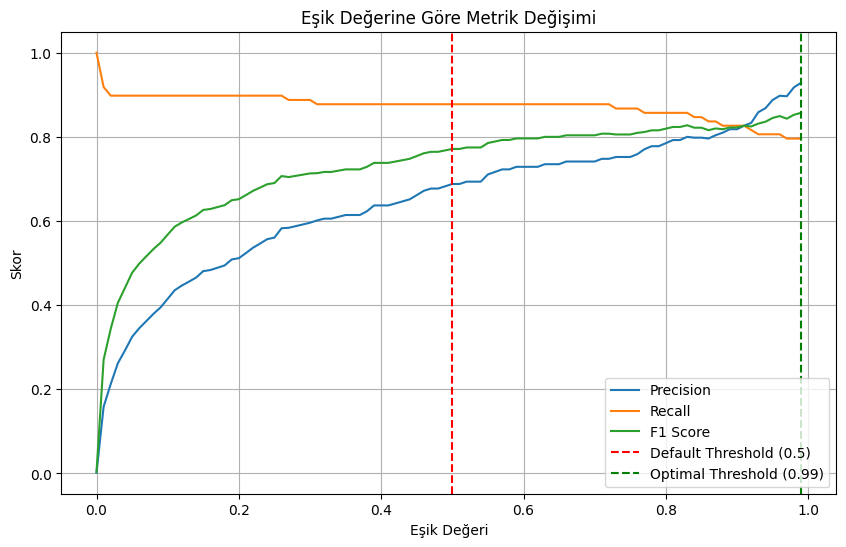

Optimum eşik değeri: 0.99
Bu eşik değerinde F1: 0.8571
Bu eşik değerinde Precision: 0.9286
Bu eşik değerinde Recall: 0.7959


In [15]:
thresholds = np.arange(0, 1, 0.01)
precision_scores = []
recall_scores = []
f1_scores = []

for threshold in thresholds:
    # Verilen eşik değerine göre tahminleri oluştur
    y_pred = (test_probs_xgb >= threshold).astype(int)
    
    # Metrikleri hesapla
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Sonuçları görselleştirelim
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.axvline(x=0.5, color='r', linestyle='--', label='Default Threshold (0.5)')

# En yüksek F1 skoruna sahip eşik değerini bulalım
optimal_threshold_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_threshold_idx]
plt.axvline(x=optimal_threshold, color='g', linestyle='--', 
            label=f'Optimal Threshold ({optimal_threshold:.2f})')

plt.title('Eşik Değerine Göre Metrik Değişimi')
plt.xlabel('Eşik Değeri')
plt.ylabel('Skor')
plt.legend()
plt.grid(True)
plt.show()

print(f"Optimum eşik değeri: {optimal_threshold:.2f}")
print(f"Bu eşik değerinde F1: {f1_scores[optimal_threshold_idx]:.4f}")
print(f"Bu eşik değerinde Precision: {precision_scores[optimal_threshold_idx]:.4f}")
print(f"Bu eşik değerinde Recall: {recall_scores[optimal_threshold_idx]:.4f}")


In [16]:
print("Model Eğitimi ve Değerlendirme Özeti:")
print("-" * 50)
print(f"Eğitim Seti Boyutu: {X_train.shape} ({X_train.shape[0]} örnek, {X_train.shape[1]} özellik)")
print(f"Test Seti Boyutu: {X_test.shape} ({X_test.shape[0]} örnek, {X_test.shape[1]} özellik)")
print("-" * 50)
print("XGBoost Performansı (Test Seti):")
print(f"F1 Skoru (Default 0.5): {f1_score(y_test, test_preds_xgb):.4f}")
print(f"F1 Skoru (Optimum {optimal_threshold:.2f}): {f1_scores[optimal_threshold_idx]:.4f}")
print(f"AUC: {roc_auc_xgb:.4f}")
print("-" * 50)
print("Lojistik Regresyon Performansı (Test Seti):")
print(f"F1 Skoru: {f1_score(y_test, test_preds_lr):.4f}")
print(f"AUC: {roc_auc_lr:.4f}")
print("-" * 50)
print("En Önemli 5 Özellik:")
for idx, row in feature_importance.head(5).iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

# Modelleri kaydedelim
import os
if not os.path.exists(MODELS_DIR):
    os.makedirs(MODELS_DIR)

# XGBoost modelini kaydet
model_path = os.path.join(MODELS_DIR, 'xgboost_model.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(xgb_model, f)
print(f"XGBoost modeli kaydedildi: {model_path}")

# Lojistik Regresyon modelini kaydet
model_path = os.path.join(MODELS_DIR, 'logistic_regression_model.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(lr_model, f)
print(f"Lojistik Regresyon modeli kaydedildi: {model_path}")

# En iyi XGBoost modelini kaydet
model_path = os.path.join(MODELS_DIR, 'best_xgboost_model.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)
print(f"En iyi XGBoost modeli kaydedildi: {model_path}")

# Optimum eşik değerini bir dosyaya kaydet
threshold_path = os.path.join(MODELS_DIR, 'xgboost_optimal_threshold.txt')
with open(threshold_path, 'w') as f:
    f.write(str(optimal_threshold))
print(f"Optimum eşik değeri kaydedildi: {threshold_path}")

Model Eğitimi ve Değerlendirme Özeti:
--------------------------------------------------
Eğitim Seti Boyutu: (68235, 40) (68235 örnek, 40 özellik)
Test Seti Boyutu: (56962, 40) (56962 örnek, 40 özellik)
--------------------------------------------------
XGBoost Performansı (Test Seti):
F1 Skoru (Default 0.5): 0.7713
F1 Skoru (Optimum 0.99): 0.8571
AUC: 0.9828
--------------------------------------------------
Lojistik Regresyon Performansı (Test Seti):
F1 Skoru: 0.1696
AUC: 0.9710
--------------------------------------------------
En Önemli 5 Özellik:
V14: 465.9877
V10: 264.8329
V4: 57.4780
amount_cat_very_small: 50.8049
amount_cat_large: 40.4390
XGBoost modeli kaydedildi: c:\Users\PC\Desktop\fraud_eye\notebooks\..\models\xgboost_model.pkl
Lojistik Regresyon modeli kaydedildi: c:\Users\PC\Desktop\fraud_eye\notebooks\..\models\logistic_regression_model.pkl
En iyi XGBoost modeli kaydedildi: c:\Users\PC\Desktop\fraud_eye\notebooks\..\models\best_xgboost_model.pkl
Optimum eşik değeri kayde